In this notebook I will perform benchmarking of my train-test split to explore what can be considered the worst performance that is better than guessing that all items are the same.

File configuration

In [ ]:
# Directory containing labeled slices files. 
# Since this is a benchmark any would do.
labeled_dir = "../../scandata/slices loess frac=0.10_labeled"

DetectionNotClassification = False  # Set to True to replace all non-zero labels with 1


Libraries used:

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import os

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    confusion_matrix, roc_auc_score
)
from sklearn.preprocessing import label_binarize

Load stratified k-Fold masks (created in stratified_k-Fold.ipynb)

In [ ]:
masks_path = "../stratified_k-fold_masks.npy"
all_masks = np.load(masks_path, allow_pickle=True)

List all labeled files

In [4]:
labeled_files = [f for f in os.listdir(labeled_dir) if f.endswith("_slices_labeled.npy")]
selected_files = labeled_files  # Use all files by default

Load labels for each file

In [5]:
all_labels = []
for labeled_file in selected_files:
    data = np.load(os.path.join(labeled_dir, labeled_file), allow_pickle=True).item()
    labels = data["labels"]
    if DetectionNotClassification:
        labels = np.where(labels > 0, 1, 0)
    all_labels.append(labels)

In [6]:
# Zero benchmark: always predict the majority class in the training set for each fold
n_folds = len(all_masks[0])
results = []

for file_idx, (labels, masks) in enumerate(zip(all_labels, all_masks)):
    file_results = []
    for fold_idx, val_mask in enumerate(masks):
        train_mask = ~val_mask
        y_train = labels[train_mask]
        y_val = labels[val_mask]

        # Predict the majority class in training set
        majority_class = np.bincount(y_train).argmax()
        y_pred = np.full_like(y_val, majority_class)

        # ROC AUC for multiclass requires binarized labels (one-hot)
        classes = np.unique(labels)
        y_val_bin = label_binarize(y_val, classes=classes)
        y_pred_bin = label_binarize(y_pred, classes=classes)
        if len(classes) > 1 and y_val_bin.shape[1] > 1:
            roc_auc = roc_auc_score(y_val_bin, y_pred_bin, average="macro", multi_class="ovo")
        else:
            roc_auc = np.nan

        # Calculate metrics
        metrics = {
            "accuracy": accuracy_score(y_val, y_pred),
            "precision": precision_score(y_val, y_pred, average='macro', zero_division=0),
            "recall": recall_score(y_val, y_pred, average='macro', zero_division=0),
            "f1": f1_score(y_val, y_pred, average='macro', zero_division=0),
            "roc_auc": roc_auc,
            "confusion_matrix": confusion_matrix(y_val, y_pred).tolist(),
            "majority_class": int(majority_class),
            "fold": fold_idx,
        }
        file_results.append(metrics)
    results.append(file_results)

Summary of results

                                                    accuracy  precision  \
file                                                                      
221111_144114__binary_onlylines114378to117271 l...  0.637931   0.212644   
221111_144114__binary_onlylines145900to148050 l...  0.703700   0.234567   
221111_144114__binary_onlylines25660to28100 loe...  0.693878   0.231293   
221111_144114__binary_onlylines47178to50517 loe...  0.739530   0.246510   
221111_144114__binary_onlylines86841to90142 loe...  0.709995   0.236665   

                                                      recall        f1  \
file                                                                     
221111_144114__binary_onlylines114378to117271 l...  0.333333  0.259649   
221111_144114__binary_onlylines145900to148050 l...  0.333333  0.275351   
221111_144114__binary_onlylines25660to28100 loe...  0.333333  0.273092   
221111_144114__binary_onlylines47178to50517 loe...  0.333333  0.283415   
221111_144114__binary_onlyline

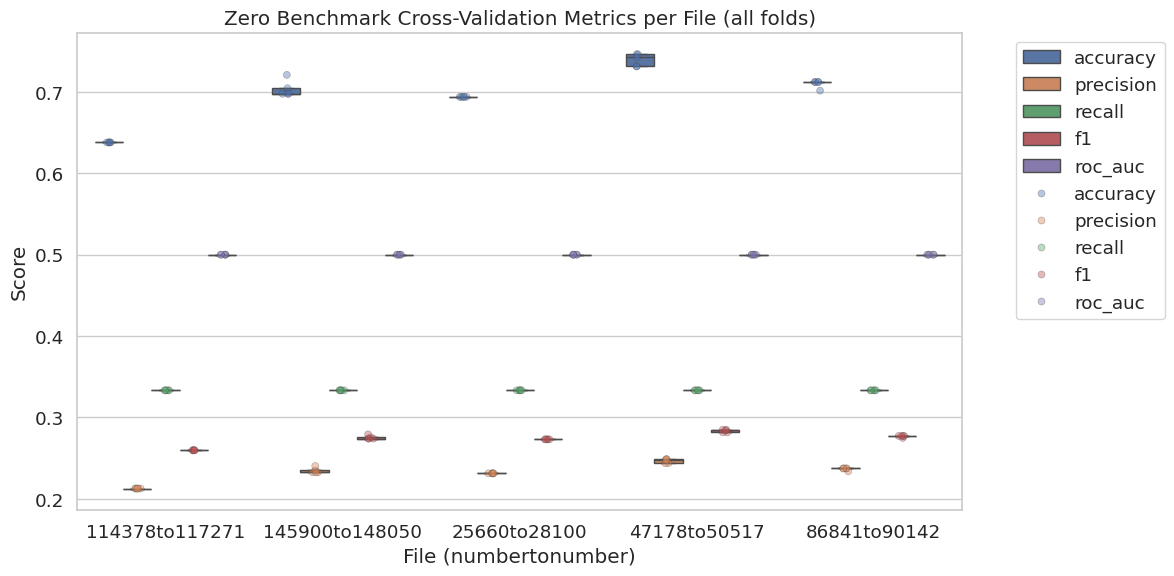

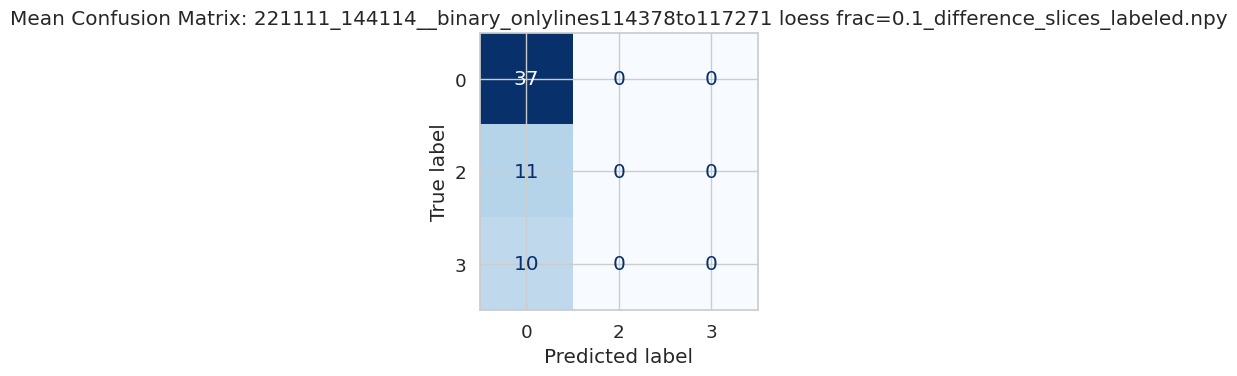

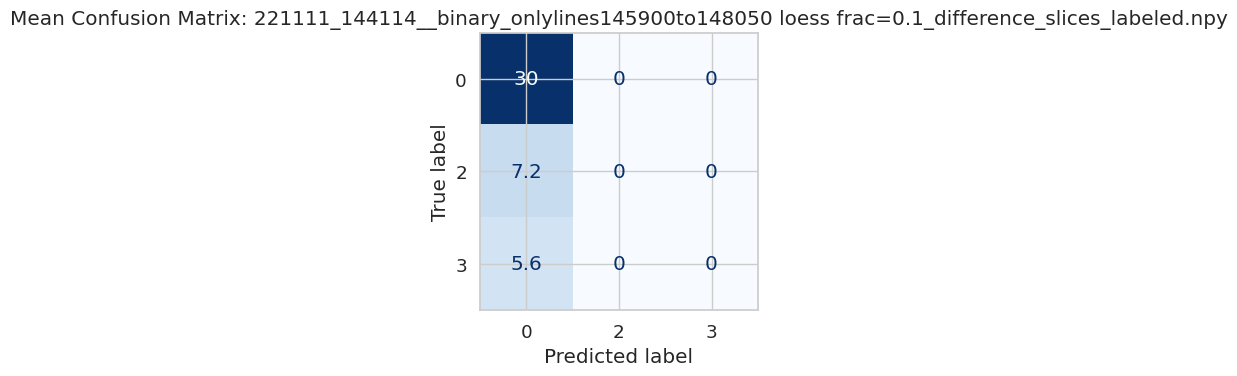

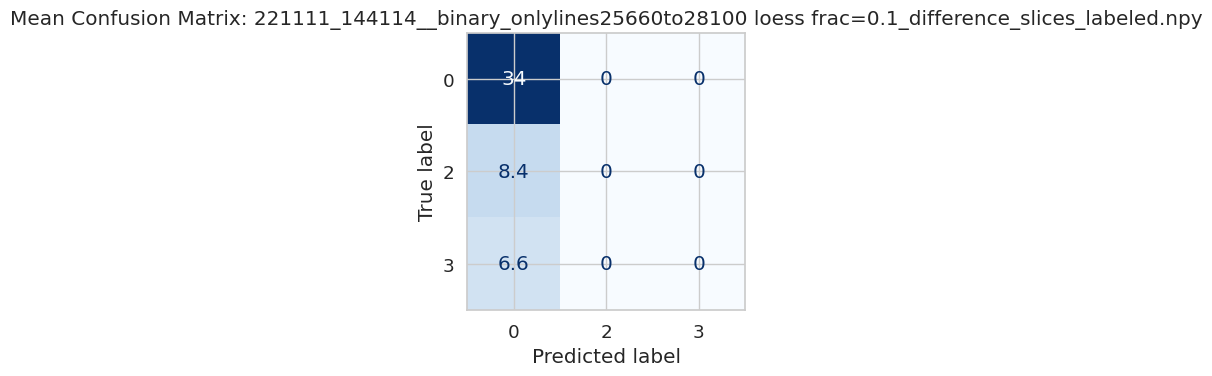

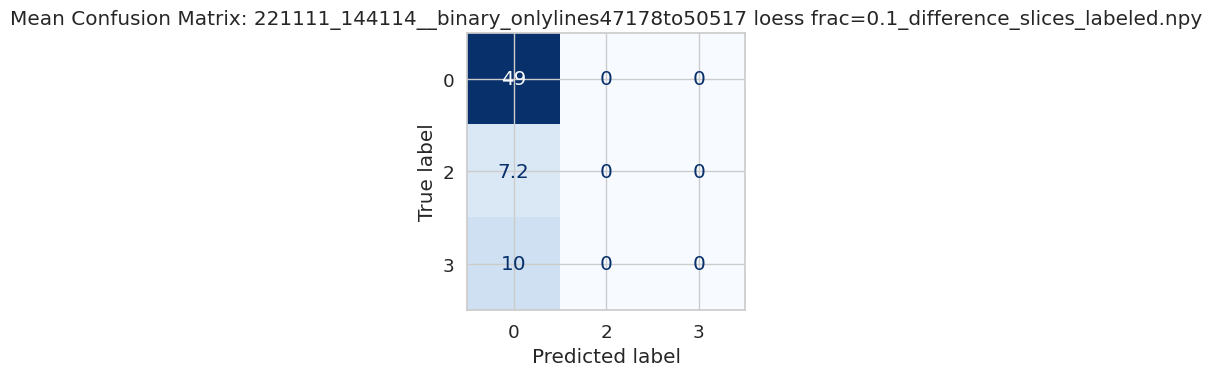

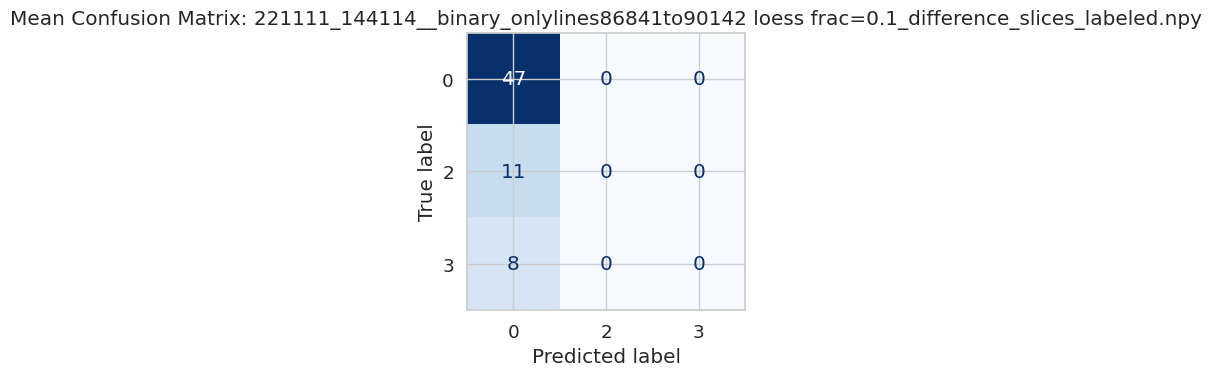

In [7]:
summary = []
for file_idx, file_results in enumerate(results):
    for fold_metrics in file_results:
        row = {"file": selected_files[file_idx], "fold": fold_metrics["fold"]}
        row.update({k: v for k, v in fold_metrics.items() if k != "confusion_matrix"})
        summary.append(row)
df = pd.DataFrame(summary)

# Print mean metrics per file
print(df.groupby("file")[["accuracy", "precision", "recall", "f1", "roc_auc"]].mean())

# Improved visualization
import seaborn as sns

# Set style
sns.set(style="whitegrid", font_scale=1.2)

# Shorten file names for plotting: extract the first numbertonumber pattern from each file name
import re

def extract_numbertonumber(filename):
    match = re.search(r'(\d+to\d+)', filename)
    return match.group(1) if match else filename

df["short_file"] = df["file"].apply(extract_numbertonumber)

# Melt DataFrame for easier plotting
metrics_to_plot = ["accuracy", "precision", "recall", "f1", "roc_auc"]
df_melt = df.melt(id_vars=["short_file", "fold"], value_vars=metrics_to_plot, var_name="Metric", value_name="Score")

plt.figure(figsize=(12, 6))
ax = sns.boxplot(data=df_melt, x="short_file", y="Score", hue="Metric", showfliers=False)
sns.stripplot(data=df_melt, x="short_file", y="Score", hue="Metric", dodge=True, alpha=0.4, linewidth=0.5, marker="o")
plt.title("Zero Benchmark Cross-Validation Metrics per File (all folds)")
plt.ylabel("Score")
plt.xlabel("File (numbertonumber)")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

# Show confusion matrix for each file (mean over folds)
from sklearn.metrics import ConfusionMatrixDisplay

for file_idx, file_results in enumerate(results):
    cms = np.array([fold["confusion_matrix"] for fold in file_results])
    mean_cm = np.mean(cms, axis=0)
    # Get all unique classes for this file
    classes = np.unique(all_labels[file_idx])
    fig, ax = plt.subplots(figsize=(4, 4))
    disp = ConfusionMatrixDisplay(mean_cm, display_labels=classes)
    disp.plot(ax=ax, cmap="Blues", colorbar=False)
    plt.title(f"Mean Confusion Matrix: {selected_files[file_idx]}")
    plt.tight_layout()
    plt.show()
